# 03 - Quasi-Probability Workflow

Goal: compute approximate probabilities from Z-moments.

What is a quasi-probability?
- A quasi-probability is a signed distribution-like function over bitstrings.
- It can contain negative values, so it is not a physical sampling distribution by itself.
- Here we build it from truncated moment expansion:
  `q^(k)(x) = 2^{-n} * sum_{S: |S|<=k} (-1)^{sum_{i in S} x_i} <Z_S>`

Intuition:
- `Z`-moments (`<Z_S>`) summarize correlations among selected qubits.
- Small `k` keeps low-order correlations only (faster, but approximate).
- Increasing `k` adds higher-order correlations (more accurate, more expensive).
- If all subsets up to order `n` are included, `q^(n)` recovers the exact probabilities (for small systems used as reference).

Core objects:
- `z_combos`: subset list defining which correlators are used
- `moments`: computed values of `<Z_S>` in that order
- `q^(k)`: reconstructed quasi-probability at order `k`


In [1]:
import os
import sys
import inspect

# Ensure this notebook imports local repo code, not an installed stale package.
repo_root = os.path.abspath(os.path.join(os.getcwd(), '..')) if os.path.basename(os.getcwd()) == 'Tutorial' else os.getcwd()
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import torch

from src.pauli_surrogate_python import PauliRotation, CliffordGate
from src_tensor.api import build_quasi_sampler
import src_tensor.tensor_sampler as ts

print('src_tensor.tensor_sampler path:', ts.__file__)
src = inspect.getsource(ts.TensorSparseSampler.quasi_prob_from_moments)
print('uses generic order loop:', 'for subset_order in self.z_spec.orders' in src)


src_tensor.tensor_sampler path: /home/quantum/Pauli-Propagation---GPU-acceleration/src_tensor/tensor_sampler.py
uses generic order loop: True


In [2]:
from itertools import combinations

n_qubits = 4
max_order = 4

circuit = [
    CliffordGate("H", [0]),
    CliffordGate("CNOT", [0, 1]),
    PauliRotation("ZZ", [1, 2], param_idx=0),
    PauliRotation("XX", [2, 3], param_idx=1),
]

z_combos = []
for k in range(1, max_order + 1):
    z_combos.extend([list(c) for c in combinations(range(n_qubits), k)])

sampler = build_quasi_sampler(
    n_qubits=n_qubits,
    circuit=circuit,
    z_combos=z_combos,
    max_order=max_order,
    preset="gpu_full",
)


propagate: 100%|██████████| 4/4 [00:00<00:00, 22.81it/s]


zero_filter_backprop: K 15->7 (0.467), n_out 31->7 (0.226), dt=0.133s


## How to read `q^(k)(x)` in practice

- `q^(k)(x) > 0`: state `x` is supported by retained correlations.
- `q^(k)(x) < 0`: truncation artifacts / interference from missing higher-order terms.
- `sum_x q^(k)(x) = 1` still holds when moments are consistent.

Why negatives are useful (despite not being directly sampleable):
- They still provide a differentiable surrogate objective for training.
- They preserve low-order statistics exactly up to selected order.
- As `k` increases, negatives typically shrink and `q^(k)` approaches true probabilities.

Sanity checks you should always run:
1. `sum(q)` close to 1
2. moment-level error vs exact reference
3. full-distribution error (`max|q-p|`, `L1`) on small-n examples

This notebook prints all three to separate: moment errors, reconstruction errors, and indexing/ordering mistakes.


## Compute moments and validate against exact probabilities

This section checks three things separately:
1. moment correctness
2. reconstruction correctness from moments to `q(x)`
3. final match to PennyLane exact probabilities


In [12]:
thetas = torch.tensor([0.3, -0.4], dtype=torch.float64)

moments = sampler.compute_moments(thetas)
print("moments shape:", tuple(moments.shape))


moments shape: (15,)


q^(3) (selected x): tensor([ 0.4178, -0.0625,  0.0625], device='cuda:0', dtype=torch.float64)

Comparison (selected x):
  x=0000  q^(3)= 4.177652e-01  p_exact(be)= 4.802652e-01  p_exact(le)= 4.802652e-01
  x=0101  q^(3)=-6.250000e-02  p_exact(be)= 0.000000e+00  p_exact(le)= 0.000000e+00
  x=1110  q^(3)= 6.250000e-02  p_exact(be)= 0.000000e+00  p_exact(le)= 0.000000e+00

Full distribution comparison (all bitstrings):
  using mapping: be
  sum(p_exact)=1.000000  sum(q^(3))=1.000000  min(q^(3))=-6.250000e-02
  max|q-p|=6.250000e-02  mean|q-p|=6.250000e-02  L1(q-p)=1.000000e+00

All states (sorted by p_exact):
  x=0000  p_exact= 4.802652e-01  q^(3)= 4.177652e-01  (q-p)=-6.250000e-02
  x=1100  p_exact= 4.802652e-01  q^(3)= 4.177652e-01  (q-p)=-6.250000e-02
  x=0011  p_exact= 1.973475e-02  q^(3)=-4.276525e-02  (q-p)=-6.250000e-02
  x=1111  p_exact= 1.973475e-02  q^(3)=-4.276525e-02  (q-p)=-6.250000e-02
  x=0001  p_exact= 0.000000e+00  q^(3)= 6.250000e-02  (q-p)= 6.250000e-02
  x=0010  p_exac

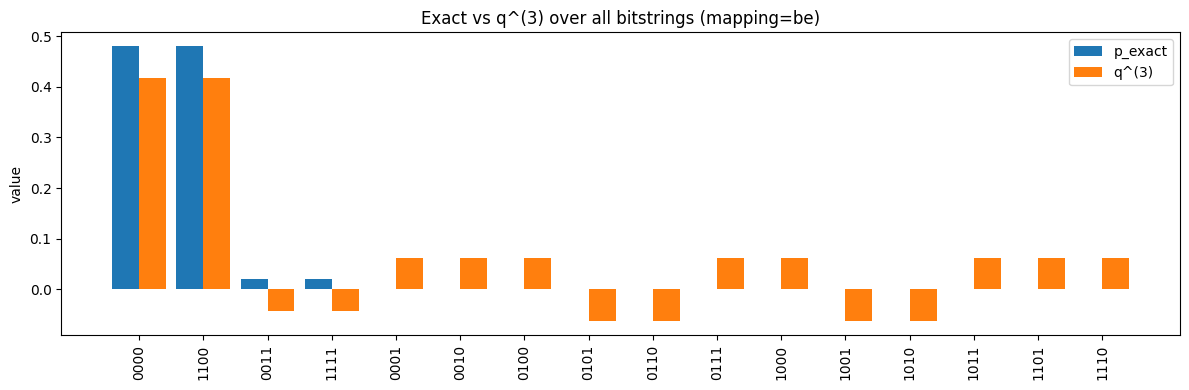

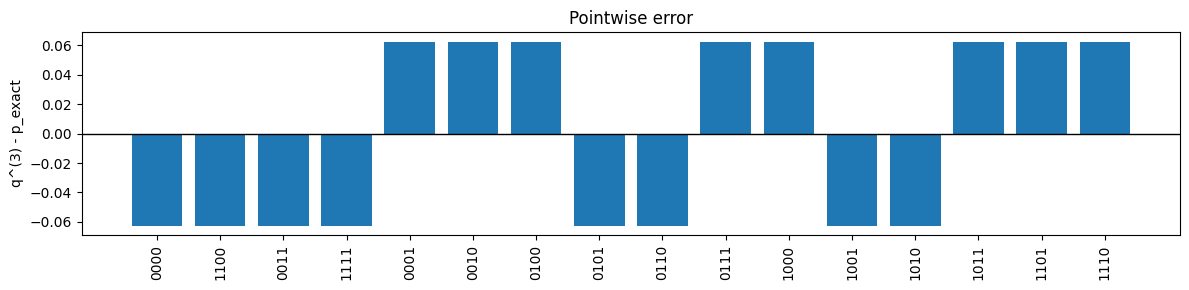

In [13]:
import numpy as np
import pennylane as qml

order_eval = 4

def _apply_circuit_pennylane(circuit, thetas_np):
    for gate in circuit:
        name = type(gate).__name__
        if name == "CliffordGate":
            symbol = gate.symbol
            if symbol == "H":
                qml.Hadamard(wires=gate.qubits[0])
            elif symbol == "S":
                qml.S(wires=gate.qubits[0])
            elif symbol == "X":
                qml.PauliX(wires=gate.qubits[0])
            elif symbol == "Y":
                qml.PauliY(wires=gate.qubits[0])
            elif symbol == "Z":
                qml.PauliZ(wires=gate.qubits[0])
            elif symbol == "CNOT":
                qml.CNOT(wires=gate.qubits)
            elif symbol == "CZ":
                qml.CZ(wires=gate.qubits)
            elif symbol == "SWAP":
                qml.SWAP(wires=gate.qubits)
            else:
                raise ValueError(f"Unsupported CliffordGate symbol for PennyLane: {symbol}")
        elif name == "PauliRotation":
            theta = float(thetas_np[int(gate.param_idx)])
            qml.PauliRot(theta, gate.pauli, wires=gate.qubits)
        else:
            raise ValueError(f"Unsupported gate type for PennyLane: {name}")

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def exact_probs(thetas_np):
    _apply_circuit_pennylane(circuit, thetas_np)
    return qml.probs(wires=list(range(n_qubits)))

def _bits_le_from_int(x, n):
    return [((x >> i) & 1) for i in range(n)]

def _bit_reverse(x, n):
    y = 0
    for i in range(n):
        y = (y << 1) | ((x >> i) & 1)
    return y

thetas_np = thetas.detach().cpu().numpy().astype(np.float64)
p_be = np.asarray(exact_probs(thetas_np), dtype=np.float64)

# Our sampler uses little-endian qubit-order rows: row[i] corresponds to qubit i.
all_rows = np.array([_bits_le_from_int(code, n_qubits) for code in range(2 ** n_qubits)], dtype=np.uint8)
all_bits = torch.tensor(all_rows, dtype=torch.uint8, device=moments.device)

q_all = sampler.quasi_prob_from_moments(all_bits, moments, order=order_eval).detach().cpu().numpy().astype(np.float64)
p_all = np.array([p_be[_bit_reverse(code, n_qubits)] for code in range(2 ** n_qubits)], dtype=np.float64)

diff = q_all - p_all
print(f"order={order_eval}, max|q-p|={np.max(np.abs(diff)):.6e}, L1={np.sum(np.abs(diff)):.6e}")
print(f"sum(q)={np.sum(q_all):.12f}, sum(p)={np.sum(p_all):.12f}")


# Internal consistency check: vectorized q vs explicit loop over moments.
def q_from_moments_ref(bits_le, moments_np, combos, order, n):
    out = []
    for row in bits_le:
        acc = 1.0
        for m, sub in zip(moments_np, combos):
            if len(sub) > order:
                continue
            sign = 1.0
            for q in sub:
                sign *= (1.0 if int(row[q]) == 0 else -1.0)
            acc += sign * float(m)
        out.append(acc / float(2 ** n))
    return np.asarray(out, dtype=np.float64)

moments_np = moments.detach().cpu().numpy().astype(np.float64)
q_ref = q_from_moments_ref(all_rows, moments_np, z_combos, order_eval, n_qubits)
print(f"internal q check: max|q_vec-q_ref|={np.max(np.abs(q_all - q_ref)):.6e}")


# Moment-level check to localize mismatch source.
moments_np = moments.detach().cpu().numpy().astype(np.float64)
m_exact = []
for sub in z_combos:
    acc = 0.0
    for code in range(2 ** n_qubits):
        sign = 1.0
        for q in sub:
            sign *= (1.0 if ((code >> q) & 1) == 0 else -1.0)
        acc += sign * p_all[code]
    m_exact.append(acc)
m_exact = np.asarray(m_exact, dtype=np.float64)
mdiff = moments_np - m_exact
print(f"moments: max|dm|={np.max(np.abs(mdiff)):.6e}, mean|dm|={np.mean(np.abs(mdiff)):.6e}")

print("\nTop states by p_exact:")
top = np.argsort(-p_all)
for i in top[:8]:
    b = "".join(str(int(v)) for v in all_rows[i])
    print(f"  x={b}  p_exact={p_all[i]: .6e}  q={q_all[i]: .6e}  (q-p)={diff[i]: .3e}")


### One-shot API
You can call `sampler.quasi_prob(x_batch, thetas, order=...)` to run:
1) moment computation + 2) quasi-prob reconstruction in one line.
